# **Preprocessing the Semantic Boundaries Dataset (SBD)**

The [Semantic Boundary Dataset (SBD)](https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/data/pascal/README.md) is a dataset derived from [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/), specifically designed for segmentation tasks. Unlike PASCAL VOC, which is an older dataset, SBD provides a larger number of images and annotations for instance segmentation.  

One of SBD’s key improvements over PASCAL VOC is the accuracy of instance annotations. In VOC, each instance includes a pixel border that introduces noise, making it unsuitable for semantic segmentation and even less so for instance segmentation. SBD eliminates these borders, improving label quality.  

In terms of dataset size, the raw PASCAL VOC dataset for instance segmentation contains:  
- **1,464 images** for training  
- **1,449 images** for validation  
- **1,456 images** for testing (not publicly available)  

Meanwhile, the raw SBD dataset offers:  
- **8,498 images** for training  
- **2,857 images** for validation  

PASCAL VOC is a standard benchmark dataset for visual recognition, widely used for detection and segmentation tasks. The instance segmentation challenge in PASCAL VOC consists of 20 object classes, and SBD maintains the same categorization.  

## **Imports**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from tqdm.auto import tqdm
from google.colab import drive
from scipy.io import loadmat
import shutil
import yaml
import cv2
import os

In [ ]:
# Mount Google Drive in Colab
drive.mount("/content/drive")

Mounted at /content/drive


## **Parameters**

In [2]:
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
classes_url = "https://raw.githubusercontent.com/shelhamer/fcn.berkeleyvision.org/refs/heads/master/data/pascal/classes.txt"
dataset_dir = "/content/SBD"
zip_dataset_path = "/content/drive/MyDrive/Datasets/SBD.zip"

os.makedirs(dataset_dir, exist_ok=True)

## **Download and Extract the Dataset**

In [3]:
raw_dataset_dir = tf.keras.utils.get_file(
    origin=dataset_url,
    cache_dir="/content/",
    extract=True
)
raw_dataset_dir = os.path.join(raw_dataset_dir, "benchmark_RELEASE/dataset")
raw_dataset_dir

1419539633/1419539633 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step


'/content/datasets/benchmark.tgz/benchmark_RELEASE/dataset'

In [4]:
# Load the classes, discarding the 'background' (0) and 'void' (255) classes
class_names = pd.read_csv(classes_url, header=None)
class_names = class_names.iloc[1:21, 0].reset_index(drop=True)
class_names = class_names.to_dict()

print(len(class_names))
print(class_names)

20
{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}


In [5]:
# Define the colors for each class (optional)
class_colors = {
    0: [230, 25, 75],
    1: [60, 180, 75],
    2: [255, 225, 25],
    3: [0, 130, 200],
    4: [245, 130, 48],
    5: [145, 30, 180],
    6: [0, 0, 128],
    7: [240, 50, 230],
    8: [210, 245, 60],
    9: [250, 190, 190],
    10: [0, 128, 128],
    11: [220, 190, 255],
    12: [170, 110, 40],
    13: [255, 250, 200],
    14: [70, 240, 240],
    15: [170, 255, 195],
    16: [255, 216, 177],
    17: [255, 215, 180],
    18: [128, 128, 128],
    19: [128, 128, 0]
}

## **Preprocess the Dataset**

In [6]:
# Load the TXT files containing the names of the training and validation files
train_filenames = pd.read_csv(os.path.join(raw_dataset_dir, "train.txt"), header=None)
val_filenames = pd.read_csv(os.path.join(raw_dataset_dir, "val.txt"), header=None)

len(train_filenames), len(val_filenames)

(8498, 2857)

In instance segmentation, verifying whether duplicate contours exist for a given instance is more complex compared to object detection. This is because some contours may differ slightly in one or more coordinates. As a result, simply adding them to a Python set would not detect them as duplicates.  

To address this issue, duplicates are identified by comparing the bounding box coordinates of each contour rather than the individual contour coordinates.

In [7]:
# Function to remove duplicate labels
def remove_duplicates(labels):
  bboxes = set()
  unique_labels = []

  for label in labels:
    polygon = np.array(label[1:], dtype=np.float32).reshape(-1, 2)
    xmin, ymin = polygon.min(axis=0)
    xmax, ymax = polygon.max(axis=0)
    bbox = (xmin, ymin, xmax, ymax)

    if bbox not in bboxes:
      bboxes.add(bbox)
      unique_labels.append(label)

  return unique_labels

For instance segmentation using [Ultralytics YOLO](https://docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format), each row in the labels corresponding to an image must follow this format:  

**`class_index, x1, y1, ..., xn, yn`**  

Where:  
- Each row represents an object instance.  
- The contour or polygon coordinates are normalized within the range $[0, 1]$.  
- Each instance must have at least **three (X, Y) coordinate pairs**.  
- Each object instance must have **only one contour**.  

SBD segmentation masks are stored as binary masks, where **0 represents the background** and **1 denotes the pixels of a specific instance**. To use these masks in YOLO, they must be converted into contour coordinates using OpenCV’s `cv2.findContours`.  

However, `cv2.findContours` may return multiple contours for a single binary mask when an instance is fragmented into several pixel groups. This is not ideal because, for convex objects, **each instance should be represented by a single group of pixels**.  

In the SBD dataset, some binary masks contain multiple pixel groups for convex objects, often due to small scattered fragments. When converting these masks into contour coordinates, multiple contours may be generated for a single instance, which is undesirable. Therefore, if an image contains at least one instance with more than one contour, it is completely discarded, as it could introduce noise during the fine-tuning of a YOLO model.  

Given this issue, it would be advisable for the **PASCAL VOC** and **SBD** datasets to improve their instance segmentation annotations by refining their binary masks or, ideally, providing the polygon coordinates that enclose each instance directly.

In [8]:
# Function to preprocess and save images and masks
def save_data(filenames, split="train"):

  # Create the image and label directories
  images_dir = os.path.join(dataset_dir, split, "images")
  labels_dir = os.path.join(dataset_dir, split, "labels")

  os.makedirs(images_dir, exist_ok=True)
  os.makedirs(labels_dir, exist_ok=True)

  for filename in tqdm(filenames):
    # Find the paths of the image and annotation, as well as the image dimensions
    image_path = os.path.join(raw_dataset_dir, f"img/{filename}.jpg")
    annotation_path = os.path.join(raw_dataset_dir, f"inst/{filename}.mat")
    width, height = Image.open(image_path).size

    # Load the annotation corresponding to the image
    annotation = loadmat(annotation_path)
    annotation = annotation["GTinst"][0][0]

    # Generate binary masks for each instance
    general_mask = annotation[0]
    masks = [
        (general_mask == i).astype(np.uint8)
        for i in np.unique(general_mask) if i != 0
    ]

    # Extract the classes for each instance
    classes = annotation[2].flatten() - 1

    if len(masks) != len(classes):
      print(f"Number of masks different from the number of classes in: {filename}")
      continue

    labels = []
    invalid_mask = False

    for cls, mask in zip(classes, masks):
      # Find the contours for each binary mask
      contour, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      # Discard masks with more than one contour or with fewer than 3 XY points
      if (len(contour) != 1) or (len(contour[0]) < 3):
        invalid_mask = True
        break

      # Normalize the contour coordinates
      contour = contour[0].squeeze().astype(np.float32)
      contour[:, 0] /= width
      contour[:, 1] /= height
      contour = np.clip(contour, 0, 1)
      contour = contour.flatten().tolist()

      labels.append([cls] + contour)

    # Discard images with invalid masks
    if invalid_mask:
      #print(f"Invalid mask in {filename}")
      continue

    # Remove duplicate labels
    labels = remove_duplicates(labels)

    # Discard empty labels
    if not labels:
      print(f"No labels present in {filename}")
      continue

    # Save the images and labels
    with open(os.path.join(labels_dir, f"{filename}.txt"), "w") as file:
      for row in labels:
        file.write(f"{' '.join([str(e) for e in row])}\n")

    shutil.copy(image_path, os.path.join(images_dir, f"{filename}.jpg"))

In [9]:
save_data(train_filenames.values.flatten())
save_data(val_filenames.values.flatten(), split="val")

  0%|          | 0/8498 [00:00<?, ?it/s]

  0%|          | 0/2857 [00:00<?, ?it/s]

In [10]:
# Number of images and labels after preprocessing
print(
    len(glob(os.path.join(dataset_dir, "train/images/*.jpg"))),
    len(glob(os.path.join(dataset_dir, "train/labels/*.txt")))
)

print(
    len(glob(os.path.join(dataset_dir, "val/images/*.jpg"))),
    len(glob(os.path.join(dataset_dir, "val/labels/*.txt")))
)

6929 6929
2303 2303


In [11]:
# Create and save the YAML file with the dataset metadata
metadata = {
    "path": f"../{os.path.basename(dataset_dir)}",
    "train": "train/images",
    "val": "val/images",
    "names": class_names,
    "colors": class_colors
}

with open(os.path.join(dataset_dir, "data.yaml"), "w") as file:
  yaml.dump(metadata, file, default_flow_style=False, sort_keys=False)

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Exploratory Data Analysis (EDA)**

In [12]:
# Function to extract instance counts per class
def count_instances(data_dir):
  list_names = list(class_names.values())
  dic_classes = {name: 0 for name in list_names}
  label_paths = glob(os.path.join(data_dir, "*.txt"))

  for path in tqdm(label_paths):
    with open(path, "r") as file:
      classes = [int(row.split()[0]) for row in file.readlines()]

    names = np.array(list_names)[classes]
    for name in names:
      dic_classes[name] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  return df

In [13]:
num_train_instances = count_instances(os.path.join(dataset_dir, "train/labels"))
num_val_instances = count_instances(os.path.join(dataset_dir, "val/labels"))

  0%|          | 0/6929 [00:00<?, ?it/s]

  0%|          | 0/2303 [00:00<?, ?it/s]

In [14]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00


In [15]:
# Function to plot a barplot of class counts
def plot_counts(num_instances, split="training", renderer=None):
  num_instances = num_instances.sort_values(by="Count")
  fig = px.bar(
      num_instances, x="Count", y="Class", title="Counts of Classes",
      text="Count", color="Count",
      color_continuous_scale=[(0, "#D80000"), (0.5, "lightblue"), (1, "#003299")]
  )

  total_count = num_instances.Count.sum()
  fig.update_layout(
      title=dict(
          text=f"Class Count in the {split.capitalize()} Set (Total: {total_count})",
          font=dict(size=15, weight="bold"),
          x=0.5
      ),
      xaxis_title=dict(text="Frequency", font=dict(size=12, weight="bold")),
      yaxis_title=dict(text="Class", font=dict(size=12, weight="bold")),
      height=600,
      width=1200
  )
  fig.show(renderer=renderer)

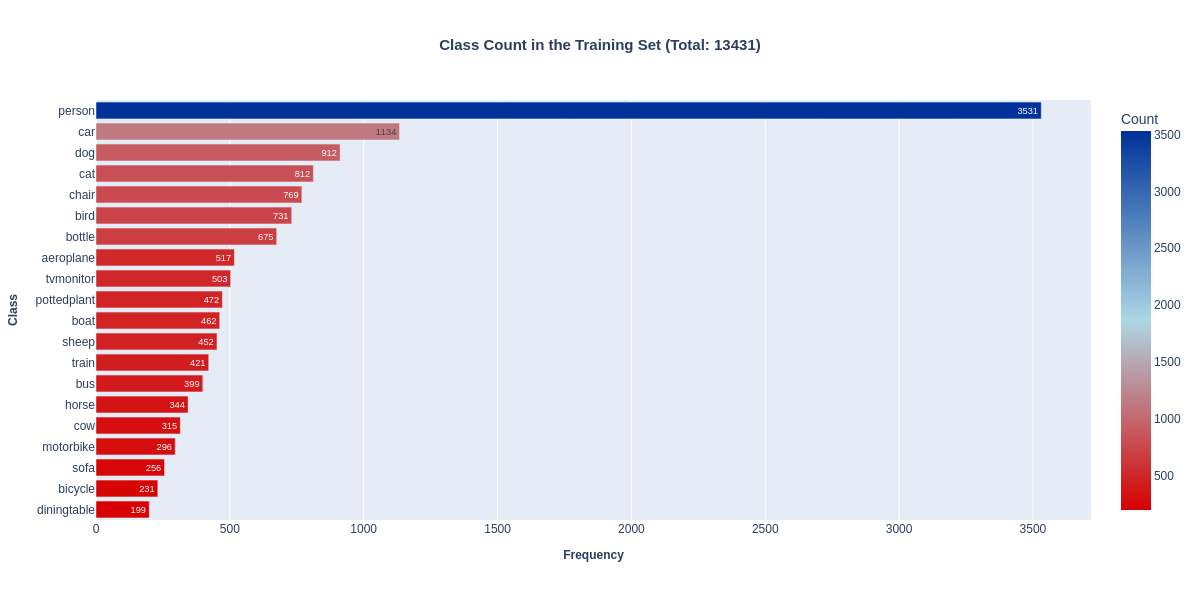

In [18]:
plot_counts(num_train_instances)
plot_counts(num_train_instances, renderer="png")

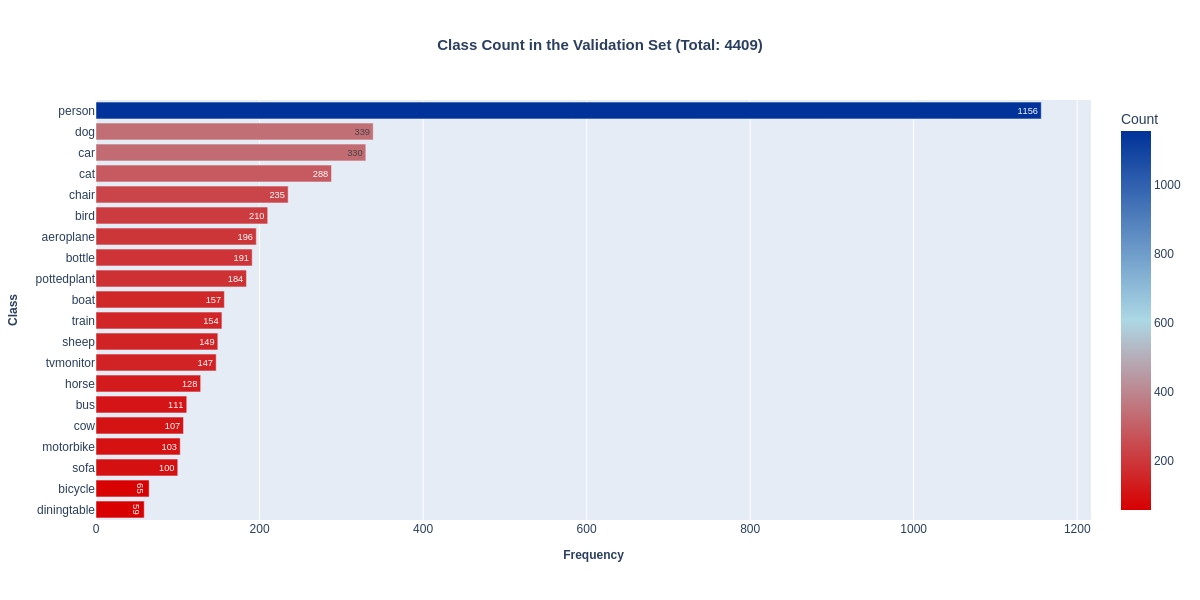

In [17]:
plot_counts(num_val_instances, split="validation")
plot_counts(num_val_instances, split="validation", renderer="png")

It can be observed that, in both the training and validation datasets, the classes with the fewest instances are `sofa`, `bicycle`, and `dining table`. Therefore, instance segmentation models fine-tuned on this dataset are expected to perform worse on these classes. Conversely, the classes with the most instances are `person`, `car`, and `dog`, so the models are expected to achieve better performance on these classes.

## **Visualization Example**

In [ ]:
train_image_paths = sorted(glob(os.path.join(dataset_dir, "train/images/*.jpg")))
train_label_paths = sorted(glob(os.path.join(dataset_dir, "train/labels/*.txt")))

In [ ]:
id = 3040 #np.random.randint(len(train_image_paths))

image = np.array(Image.open(train_image_paths[id]))

with open(train_label_paths[id], "r") as file:
  labels = [row.split() for row in file.readlines()]

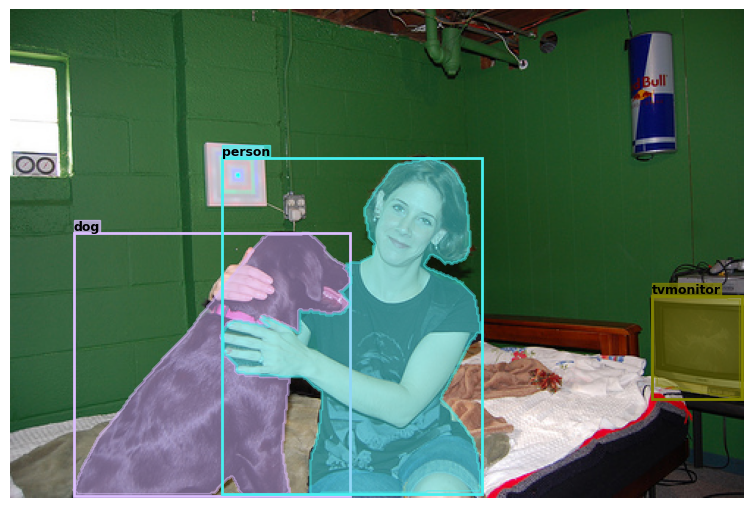

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 8))
shape = image.shape

ax.imshow(image)
for contour in labels:
  cls = int(contour[0])
  color = class_colors[cls]
  color = tuple(np.array(color) / 255)

  contour = np.array(contour[1:]).reshape(-1, 2).astype(np.float32)
  contour[:, 0] *= shape[1]
  contour[:, 1] *= shape[0]
  polygon = patches.Polygon(contour, facecolor=color, edgecolor=color, alpha=0.5, linewidth=2)

  xmin, ymin = contour.min(axis=0)
  xmax, ymax = contour.max(axis=0)
  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor="none")

  ax.add_patch(polygon)
  ax.add_patch(rect)
  ax.text(
      x=xmin, y=ymin, s=f"{class_names[cls]}",
      color="black", fontsize=9, fontweight="bold", ha="left", va="bottom",
      bbox={"boxstyle": "square,pad=0", "facecolor": color, "edgecolor": color, "alpha": 0.7}
  )

plt.tight_layout()
ax.axis("off");